In [250]:
import numpy as np
from types import SimpleNamespace
from scipy import optimize
from matplotlib import pyplot as plt
from numba import jit

## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

In [68]:
# define parameter namespace
par = SimpleNamespace()
par.eta = 0.5
par.w = 1.0

kappa = [1.0, 2.0]

# profit function as defined in assignment text
def profits(par, ell, kappa):
    return kappa*ell**(1-par.eta)-par.w*ell

# optimal ell based on analytical solution
def ell_opt_anal(par, kappa):
    """
    Calculates the optimal value of ell based on the analytical solution.

    Parameters:
    - par: Parameter object containing model parameters.
    - kappa: Array of kappa values.

    Returns:
    - ell_opt: Array of optimal ell values corresponding to each kappa value.
    """
    ell_opt = [None]*len(kappa)
    for i, k in enumerate(kappa):
        ell_opt[i] = ((1-par.eta)*k/par.w)**(1/par.eta)
    return ell_opt

# rule els based on rule for question 2.2 sames as analytical, but non list based inputs
def ell_opt_rulebased(par, kappa): 
    return ((1-par.eta)*kappa/par.w)**(1/par.eta)

# optimal ell 
def sol_ell(par, kappa):
    res = [None] * len(kappa)
    #loop through kappas
    for i, k in enumerate(kappa):
        print(k)
        #define objective function 
        obj = lambda ell: -profits(par, ell, k)
        # call optimizer from scipy
        x0 = [0.1]
        res[i] = optimize.minimize(obj, [x0], method='nelder-mead', bounds=((0, np.inf), ))
    return res
res = sol_ell(par, kappa)
opt_anal = ell_opt_anal(par, kappa)

1.0
2.0


/var/folders/vd/dwydg2bx2gz3j9x78jm_tx400000gn/T/ipykernel_4083/295815056.py:31: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  res[i] = optimize.minimize(obj, [x0], method='nelder-mead', bounds=((0, np.inf), ))


In [69]:
print(res[0].x, res[1].x,opt_anal)

[0.25] [1.] [0.25, 1.0]


Optimizing numerically we find the same solution as the analytical solution. We can check this further by using the numpy "isclose" function, using this we again find that the numerical and analytical solution is the same:

In [70]:
print(np.isclose(res[0].x,opt_anal[0]),
np.isclose(res[1].x, opt_anal[1]))

[ True] [ True]


We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

In [126]:
# deffine new parameters
par.rho = 0.90
par.iota = 0.01
par.sigma = 0.1
par.R = (1+0.01)**(1/12)
par.K = 500
par.kappa_init = 1
par.T = 120
par.Delta = 0
def kappa_series(par):
    eps = np.random.normal(loc=-0.5*par.sigma**2,scale=par.sigma, size=par.T) #create T shocks
    log_kappa_ar1 = np.zeros(par.T)
    kappa_ar1 = np.zeros(par.T)
    log_kappa_ar1[0] = par.rho*np.log(par.kappa_init)+eps[0]
    kappa_ar1[0] = np.exp(log_kappa_ar1[0])
    for i in range(par.T):
        if i > 0:
            log_kappa_ar1[i] = par.rho*np.log(kappa_ar1[i-1]) + eps[i]
            kappa_ar1[i] = np.exp(log_kappa_ar1[i])
        else:
            kappa_ar1[i] = kappa_ar1[i]
            log_kappa_ar1[i] = log_kappa_ar1[i]
    return kappa_ar1
#define h function
#def h(par, eps, K): 

In [127]:
def h_func(par, shocks):
    profit_series = np.zeros(par.T)    
    ell_series = ell_opt_rulebased(par, shocks)

    for i in range(par.T):
        if i > 0 and np.abs(ell_series[i]-ell_series[i-1]) > par.Delta:
            profit_series[i] = (par.R**-i)*(profits(par, ell_series[i], shocks[i]) -par.iota)
        elif i > 0 and np.abs(ell_series[i]-ell_series[i-1]) <= par.Delta:
            ell_series[i] = ell_series[i-1] # in this case set ell_t to ell_t-1
            profit_series[i] = (par.R**-i)*profits(par, ell_series[i], shocks[i])
    return np.sum(profit_series)

@jit
def big_H(par):
    h_list = np.zeros(par.K)
    for i in range(par.K):
        shocks = kappa_series(par)
        h_list[i] = h_func(par, shocks)
    return np.mean(h_list)

In [128]:
par.Delt = 0
np.random.seed(1234)
a = big_H(par)
print(a)

27.50616707008329


Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

In [129]:
# write your code here
par.Delta= 0.05
profits_high_Delta = big_H(par)
print(profits_high_Delta)

27.823719651925064


We see that profitability is not improved for the higher $\Delta$

**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

In [246]:
# write your code here
par.K = 1000
def obj(Delta, par):
    np.random.seed(1234)
    par.Delta = Delta
    return -1* np.log(big_H(par))
def sol_Delta(par):
    bnds = ((0,1),)
    x0 = [0.01]
    res = optimize.minimize(obj, args=(par), x0=x0, method='nelder-mead')
    return res

In [247]:
optimalDelta = sol_Delta(par)

In [248]:
optimalDelta

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -3.334351723224573
             x: [ 7.544e-02]
           nit: 16
          nfev: 33
 final_simplex: (array([[ 7.544e-02],
                       [ 7.538e-02]]), array([-3.334e+00, -3.334e+00]))

In [186]:
from tqdm import tqdm 
par.K = 1000
H = np.empty(100)
Delta = np.linspace(0,1,100)
for i, d in tqdm(enumerate(Delta)):
    par.Delta = d
    H[i] = big_H(par)

100it [01:41,  1.02s/it]


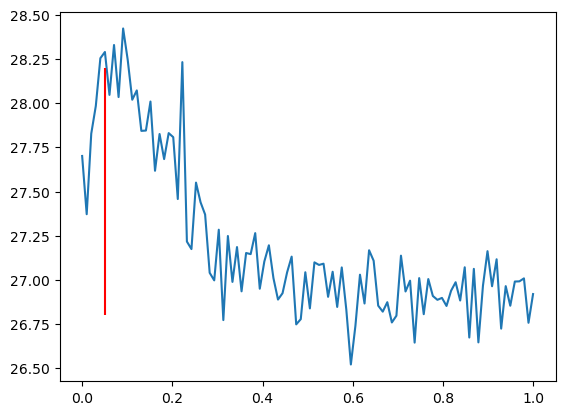

In [187]:
fig, ax = plt.subplots(1,1)
ax.plot(Delta, H)
ax.vlines(0.05, ymin=26.8, ymax=28.2, color='red')

In [188]:
from tqdm import tqdm 
par.K = 3000
H = np.empty(100)
Delta = np.linspace(0,1,100)
for i, d in tqdm(enumerate(Delta)):
    par.Delta = d
    H[i] = big_H(par)

100it [05:49,  3.50s/it]


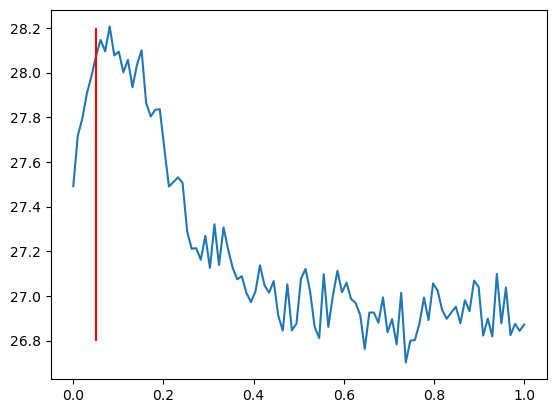

In [190]:
fig, ax = plt.subplots(1,1)
ax.plot(Delta, H)
ax.vlines(0.05, ymin=26.8, ymax=28.2, color='red')

In [191]:
from tqdm import tqdm 
par.K = 3000
H = np.empty(100)
Delta = np.linspace(0,0.3,100)
for i, d in tqdm(enumerate(Delta)):
    par.Delta = d
    H[i] = big_H(par)

100it [05:15,  3.16s/it]


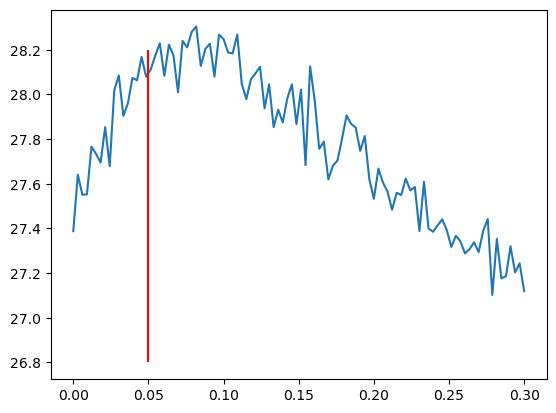

In [193]:
fig, ax = plt.subplots(1,1)
ax.plot(Delta, H)
ax.vlines(0.05, ymin=26.8, ymax=28.2, color='red')

In [254]:
from tqdm import tqdm 
par.K = 200
H = np.empty(100)
Delta = np.linspace(0,0.3,100)
for i, d in tqdm(enumerate(Delta)):
    par.Delta = d
    np.random.seed(1)
    H[i] = big_H(par)

100it [00:23,  4.20it/s]


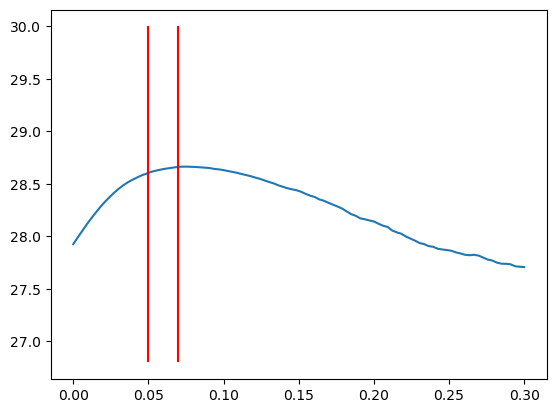

In [255]:
fig, ax = plt.subplots(1,1)
ax.plot(Delta, H)
ax.vlines(0.05, ymin=26.8, ymax=30, color='red')
ax.vlines(0.07, ymin=26.8, ymax=30, color='red')



**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



**Question 5 Answer:**
We consider making a good guess of kappa and using this kappa in each period and setting a fixed $\ell$. Under the assumption that we as hair salon owners have access the mean of the shocks $-0.5\sigma**2$ and $\rho$.

In [231]:
def sim_ell_guess(par):
    kappa_guess = np.exp(-5*par.sigma**2/(1-par.rho))
    ell = np.full(120, ell_opt_rulebased(par, kappa_guess))
    shocks = kappa_series(par)
    profit_list = profits(par, ell, shocks)
    discounted_profits = np.zeros(120)
    for i, p in enumerate(profit_list):
        discounted_profits[i] = par.R**-i*p
    return np.sum(discounted_profits)

In [260]:
a = sim_ell_guess(par)
print(a)

27.745442180234583


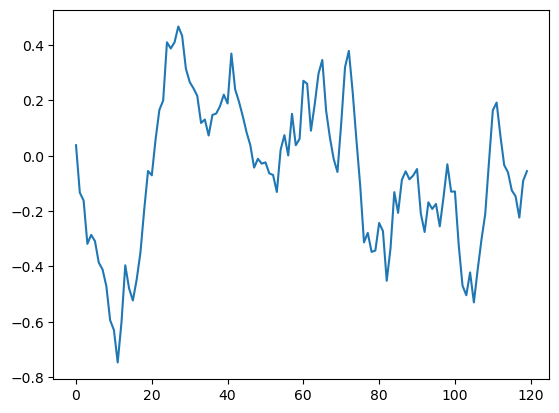

In [261]:
par.rho = 0.9
shocks = kappa_series(par)
plt.plot(np.log(shocks))

In [262]:
def sim_ell_guess_k_times(par):
    prof = np.zeros(par.K)
    np.random.seed(1)
    for i in range(par.K):
        prof[i] = sim_ell_guess(par)
    return np.mean(prof)

In [263]:
guess_profits = sim_ell_guess_k_times(par)

In [264]:
guess_profits

23.688251408616097

In [259]:
hello = sim_ell_guess(par)